In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, distinct

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# Declare a SQLAlchemy base using `automap_base()` to automatically generate my Python classes from my Postgresql DB tables
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create the SQLAlchemy inspector and connect it to the engine
# This allows the inspection of database tables from my Python code 
inspector = inspect(engine)

In [9]:
# Use SQLAlchemy reflection to get the details of the measurement table
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Use SQLAlchemy reflection to get the details of the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])


id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [12]:
measurements_df = pd.read_sql(session.query(measurement).statement, session.bind)
measurements_df.head()

,id,station,date,prcp,tobs
0,1,USC00519397,2010-01-01,0.08,65.0
1,2,USC00519397,2010-01-02,0.00,63.0
2,3,USC00519397,2010-01-03,0.00,74.0
3,4,USC00519397,2010-01-04,0.00,76.0
4,5,USC00519397,2010-01-06,NaN,73.0


# Exploratory Climate Analysis

In [13]:
# I want to know how many dates of measurement data this table covers
# This will tell me the total number of rows (but not the unique dates)
session.query(func.count(measurement.date)).all()

[(19550)]

In [14]:
# How many unique dates does the data in this table cover?
session.query(func.count(distinct(measurement.date))).all()

[(2792)]

In [15]:
# Find the earliest date
session.query(measurement.date).order_by(measurement.date).first()

('2010-01-01')

In [16]:
# Find the latest date
session.query(measurement.date).order_by(measurement.date.desc()).first()

('2017-08-23')

In [17]:
last_date = session.query(measurement.date).order_by(measurement.date.desc()).first()

In [18]:
print(last_date)

('2017-08-23',)


In [19]:
# Calculate the date 1 year ago from the last data point in the database
latest_date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
start_date = latest_date - dt.timedelta(days=365)
print(start_date)

2016-08-23 00:00:00


In [37]:
# Perform a query to retrieve the date and precipitation scores
# Sort the result by date
sel = [measurement.date, 
       func.sum(measurement.prcp)]
precipitation = session.query(*sel).\
        filter(func.strftime(measurement.date) >= start_date).\
        group_by(measurement.date).\
        order_by(measurement.date).all()
precipitation

[('2016-08-24', 9.329999999999998),
 ('2016-08-25', 0.54),
 ('2016-08-26', 0.09999999999999999),
 ('2016-08-27', 0.31999999999999995),
 ('2016-08-28', 3.0999999999999996),
 ('2016-08-29', 1.46),
 ('2016-08-30', 0.07),
 ('2016-08-31', 3.1799999999999997),
 ('2016-09-01', 0.03),
 ('2016-09-02', 0.25),
 ('2016-09-03', 1.27),
 ('2016-09-04', 1.3800000000000001),
 ('2016-09-05', 0.33999999999999997),
 ('2016-09-06', 1.23),
 ('2016-09-07', 2.0),
 ('2016-09-08', 0.4600000000000001),
 ('2016-09-09', 1.0699999999999998),
 ('2016-09-10', 1.4),
 ('2016-09-11', 1.25),
 ('2016-09-12', 1.54),
 ('2016-09-13', 2.71),
 ('2016-09-14', 14.280000000000001),
 ('2016-09-15', 4.96),
 ('2016-09-16', 0.8200000000000001),
 ('2016-09-17', 0.6799999999999999),
 ('2016-09-18', 0.53),
 ('2016-09-19', 0.32),
 ('2016-09-20', 1.03),
 ('2016-09-21', 1.17),
 ('2016-09-22', 1.44),
 ('2016-09-23', 1.57),
 ('2016-09-24', 0.28),
 ('2016-09-25', 0.09),
 ('2016-09-26', 1.67),
 ('2016-09-27', 1.3599999999999999),
 ('2016-09-28

In [38]:
# Save the query results as a Pandas DataFrame and set the index to the date column
# Remove rows with NA values
# Sort the dataframe by date

precipitation_df = pd.DataFrame(precipitation, columns=['measurement_date', 'precipitation_amount'])
precipitation_df.dropna(axis=0, how='any', inplace= True)
precipitation_df.sort_values(by='measurement_date')
precipitation_df.set_index('measurement_date', inplace=True)
precipitation_df.head()


,precipitation_amount
measurement_date,
2016-08-24,9.33
2016-08-25,0.54
2016-08-26,0.10
2016-08-27,0.32
2016-08-28,3.10


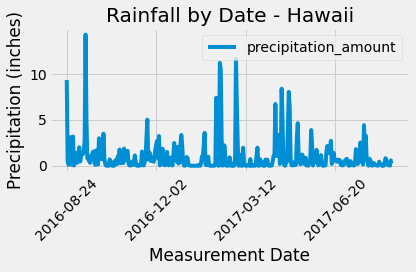

In [45]:
# Plot the Results in a Matplotlib bar chart

ax = precipitation_df.plot(rot=45, title = "Rainfall by Date - Hawaii", xlabel='Measurement Date', ylabel = "Precipitation (inches)")
# precipitation_df.plot(rot=45)
plt.tight_layout()
plt.show()
ax.figure.savefig('Annual_Precipitation_Hawaii.png', bbox_inches='tight')

In [46]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df.describe()

,precipitation_amount
count,365.000000
mean,0.974164
std,1.776466
min,0.000000
25%,0.050000
50%,0.400000
75%,1.080000
max,14.280000


In [47]:
# Design a query to show how many stations are available in this dataset?
session.query(func.count(distinct(measurement.station))).all()


[(9)]

In [64]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel = [measurement.station, 
       func.count(measurement.date)]
active_stations = session.query(*sel).\
        group_by(measurement.station).\
        order_by(func.count(measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [ ]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
